In [ ]:
!pip install google-cloud-bigquery

In [ ]:
from google.colab import auth
auth.authenticate_user()
print("Authenticated")

Authenticated


In [ ]:
from google.cloud import bigquery
project_id = "perdagangan-dataset.pph"
client = bigquery.Client(project=project_id)

In [ ]:
from google.cloud import bigquery
# Only include the project ID when initializing the client
project_id = "perdagangan-dataset"
client = bigquery.Client(project=project_id)

# Query transaksi_keuangan
query_transaksi = """
SELECT * FROM `perdagangan-dataset.pph.transaksi_keuangan`
"""
transaksi_df = client.query(query_transaksi).to_dataframe()

# Query aset_tetap
query_aset_tetap = """
SELECT * FROM `perdagangan-dataset.pph.aset_tetap`
"""
aset_tetap_df = client.query(query_aset_tetap).to_dataframe()

# Query kebijakan_fiskal
query_kebijakan_fiskal = """
SELECT * FROM `perdagangan-dataset.pph.kebijakan_fiskal`
"""
kebijakan_fiskal_df = client.query(query_kebijakan_fiskal).to_dataframe()

In [ ]:
import pandas as pd

df = pd.merge(transaksi_df, kebijakan_fiskal_df, on='tahun', how='left')

In [ ]:
df['is_tax_holiday'] = df.apply(lambda x: x['tax_holiday_awal'] <= x['tahun'] <= x['tax_holiday_akhir'] if pd.notnull(x['tax_holiday_awal']) else False, axis=1)
df['laba_sebelum_pajak'] = df['pendapatan'] - df['beban_operasional'] - df['penyusutan']
df['pajak_dengan_tax_holiday'] = df.apply(lambda x: x['laba_sebelum_pajak'] * x['tax_rate'] if not x['is_tax_holiday'] and pd.notnull(x['tax_rate']) else 0, axis=1)
df['pajak_tanpa_tax_holiday'] = df['laba_sebelum_pajak'] * df['tax_rate'].fillna(0.25)  # Default tax rate if NaN
df['laba_bersih_dengan_tax_holiday'] = df['laba_sebelum_pajak'] - df['pajak_dengan_tax_holiday']
df['laba_bersih_tanpa_tax_holiday'] = df['laba_sebelum_pajak'] - df['pajak_tanpa_tax_holiday']
df['penghematan_pajak'] = df['pajak_tanpa_tax_holiday'] - df['pajak_dengan_tax_holiday']
print("DataFrame Simulasi Tax Holiday:")
print(df[['tahun', 'skenario', 'laba_sebelum_pajak', 'pajak_dengan_tax_holiday', 'pajak_tanpa_tax_holiday',
          'laba_bersih_dengan_tax_holiday', 'laba_bersih_tanpa_tax_holiday']])

DataFrame Simulasi Tax Holiday:
    tahun skenario  laba_sebelum_pajak  pajak_dengan_tax_holiday  \
0    2020   Normal          1800000000                         0   
1    2021   Normal          1890000000                         0   
2    2021  Pesimis          1690000000                         0   
3    2022   Normal          1980000000                         0   
4    2022  Pesimis          1680000000                         0   
5    2023   Normal          2070000000                         0   
6    2023  Pesimis          1770000000                         0   
7    2024   Normal          2060000000                         0   
8    2024  Optimis          1860000000                         0   
9    2025   Normal          2050000000                         0   
10   2025  Optimis          1850000000                         0   

    pajak_tanpa_tax_holiday  laba_bersih_dengan_tax_holiday  \
0               450000000.0                      1800000000   
1               472500000

In [ ]:
aset_garis_lurus = aset_tetap_df[aset_tetap_df['metode'] == 'Garis Lurus']
def hitung_depresiasi_garis_lurus(nilai_perolehan, umur_ekonomis):
    return nilai_perolehan / umur_ekonomis
aset_garis_lurus['depresiasi_tahunan'] = aset_garis_lurus.apply(
    lambda x: hitung_depresiasi_garis_lurus(x['nilai_perolehan'], x['umur_ekonomis']), axis=1)

depresiasi_simulasi = []
for _, aset in aset_garis_lurus.iterrows():
    for tahun in sorted(transaksi_df['tahun'].unique()):
        tahun_berjalan = tahun - 2020 + 1  # Assume assets start in 2020
        if tahun_berjalan <= aset['umur_ekonomis']:
            nilai_buku = aset['nilai_perolehan'] - (aset['depresiasi_tahunan'] * tahun_berjalan)
            nilai_buku = max(0, nilai_buku)
        else:
            nilai_buku = 0
        skenario = transaksi_df[transaksi_df['tahun'] == tahun]['skenario'].iloc[0] if not transaksi_df[transaksi_df['tahun'] == tahun].empty else 'Normal'
        depresiasi_simulasi.append({
            'tahun': tahun,
            'aset_id': aset['aset_id'],
            'kategori': aset['kategori'],
            'depresiasi_tahunan': aset['depresiasi_tahunan'],
            'nilai_buku': nilai_buku,
            'skenario': skenario
        })
depresiasi_garis_lurus_df = pd.DataFrame(depresiasi_simulasi)
print("DataFrame Simulasi Depresiasi Garis Lurus:")
print(depresiasi_garis_lurus_df)

DataFrame Simulasi Depresiasi Garis Lurus:
    tahun aset_id           kategori  depresiasi_tahunan    nilai_buku  \
0    2020    A001             Gedung        5.000000e+08  9.500000e+09   
1    2021    A001             Gedung        5.000000e+08  9.000000e+09   
2    2022    A001             Gedung        5.000000e+08  8.500000e+09   
3    2023    A001             Gedung        5.000000e+08  8.000000e+09   
4    2024    A001             Gedung        5.000000e+08  7.500000e+09   
5    2025    A001             Gedung        5.000000e+08  7.000000e+09   
6    2020    A002              Mesin        5.000000e+08  4.500000e+09   
7    2021    A002              Mesin        5.000000e+08  4.000000e+09   
8    2022    A002              Mesin        5.000000e+08  3.500000e+09   
9    2023    A002              Mesin        5.000000e+08  3.000000e+09   
10   2024    A002              Mesin        5.000000e+08  2.500000e+09   
11   2025    A002              Mesin        5.000000e+08  2.000000e+0

<ipython-input-13-1651980605>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aset_garis_lurus['depresiasi_tahunan'] = aset_garis_lurus.apply(


In [ ]:
aset_saldo_menurun = aset_tetap_df[aset_tetap_df['metode'] == 'Saldo Menurun']
def hitung_depresiasi_saldo_menurun(nilai_buku, umur_ekonomis):
    rate = 2 / umur_ekonomis
    return nilai_buku * rate

depresiasi_simulasi = []
for _, aset in aset_saldo_menurun.iterrows():
    nilai_buku = aset['nilai_perolehan']
    for tahun in sorted(transaksi_df['tahun'].unique()):
        depresiasi_tahunan = hitung_depresiasi_saldo_menurun(nilai_buku, aset['umur_ekonomis'])
        nilai_buku = nilai_buku - depresiasi_tahunan
        nilai_buku = max(0, nilai_buku)
        skenario = transaksi_df[transaksi_df['tahun'] == tahun]['skenario'].iloc[0] if not transaksi_df[transaksi_df['tahun'] == tahun].empty else 'Normal'
        depresiasi_simulasi.append({
            'tahun': tahun,
            'aset_id': aset['aset_id'],
            'kategori': aset['kategori'],
            'depresiasi_tahunan': depresiasi_tahunan,
            'nilai_buku': nilai_buku,
            'skenario': skenario
        })
depresiasi_saldo_menurun_df = pd.DataFrame(depresiasi_simulasi)
print("DataFrame Simulasi Depresiasi Saldo Menurun:")
print(depresiasi_saldo_menurun_df)

DataFrame Simulasi Depresiasi Saldo Menurun:
    tahun aset_id           kategori  depresiasi_tahunan   nilai_buku skenario
0    2020    A004   Peralatan Kantor         200000000.0  300000000.0   Normal
1    2021    A004   Peralatan Kantor         120000000.0  180000000.0   Normal
2    2022    A004   Peralatan Kantor          72000000.0  108000000.0   Normal
3    2023    A004   Peralatan Kantor          43200000.0   64800000.0   Normal
4    2024    A004   Peralatan Kantor          25920000.0   38880000.0   Normal
5    2025    A004   Peralatan Kantor          15552000.0   23328000.0   Normal
6    2020    A007  Inventaris Kantor         120000000.0  180000000.0   Normal
7    2021    A007  Inventaris Kantor          72000000.0  108000000.0   Normal
8    2022    A007  Inventaris Kantor          43200000.0   64800000.0   Normal
9    2023    A007  Inventaris Kantor          25920000.0   38880000.0   Normal
10   2024    A007  Inventaris Kantor          15552000.0   23328000.0   Normal
11   20

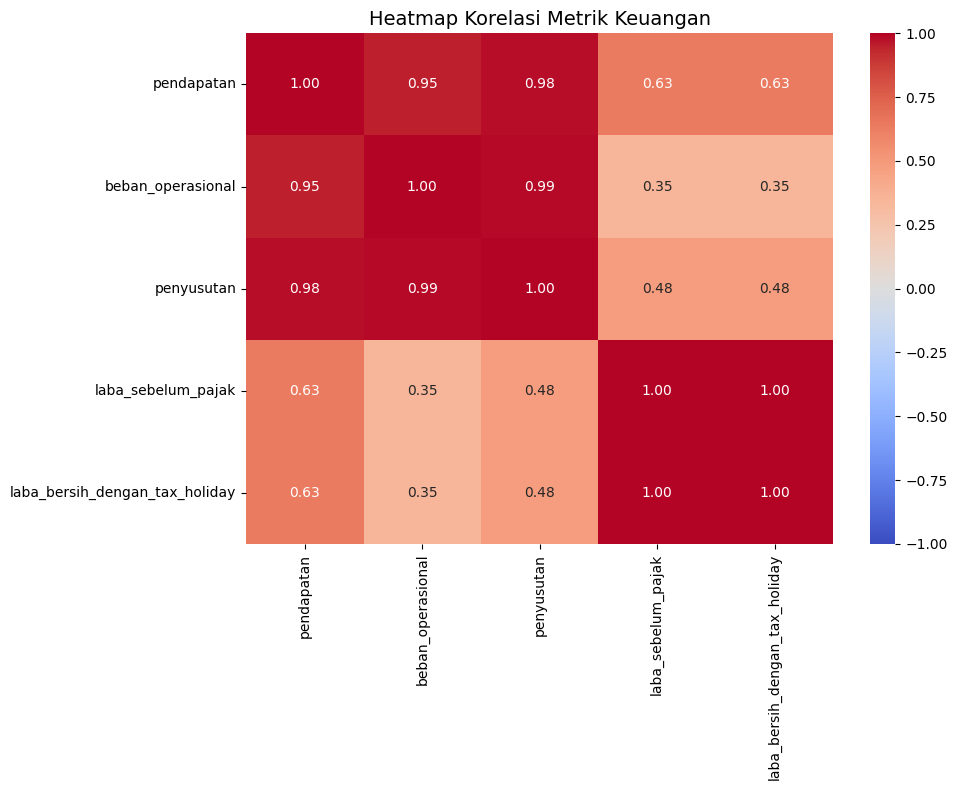

<Figure size 1200x600 with 0 Axes>

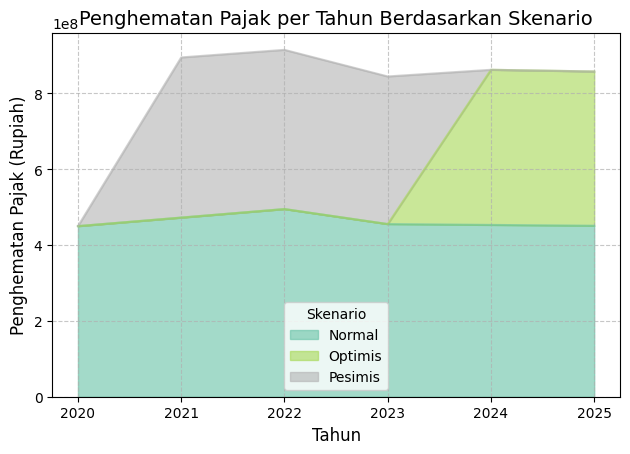

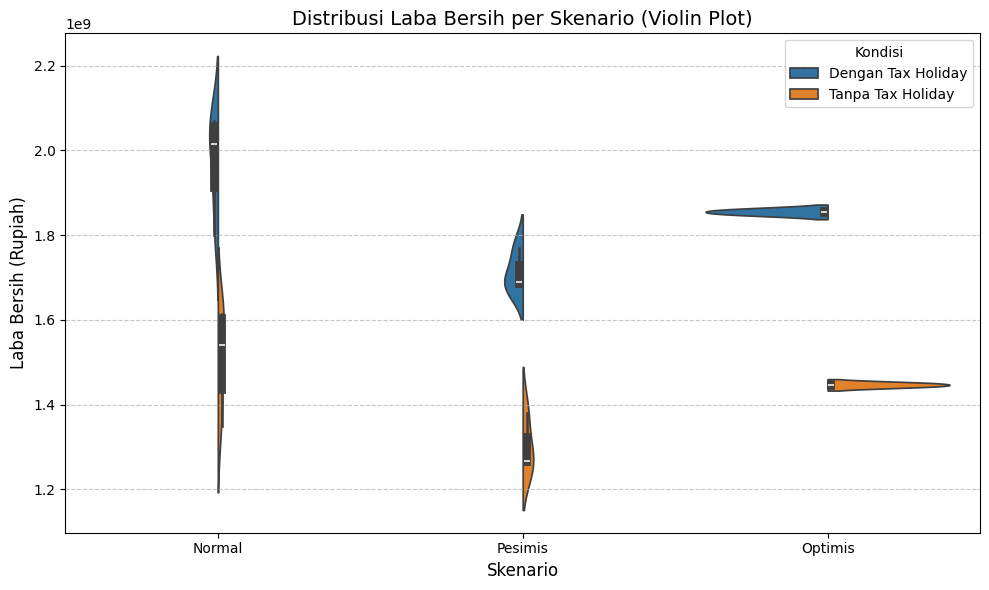

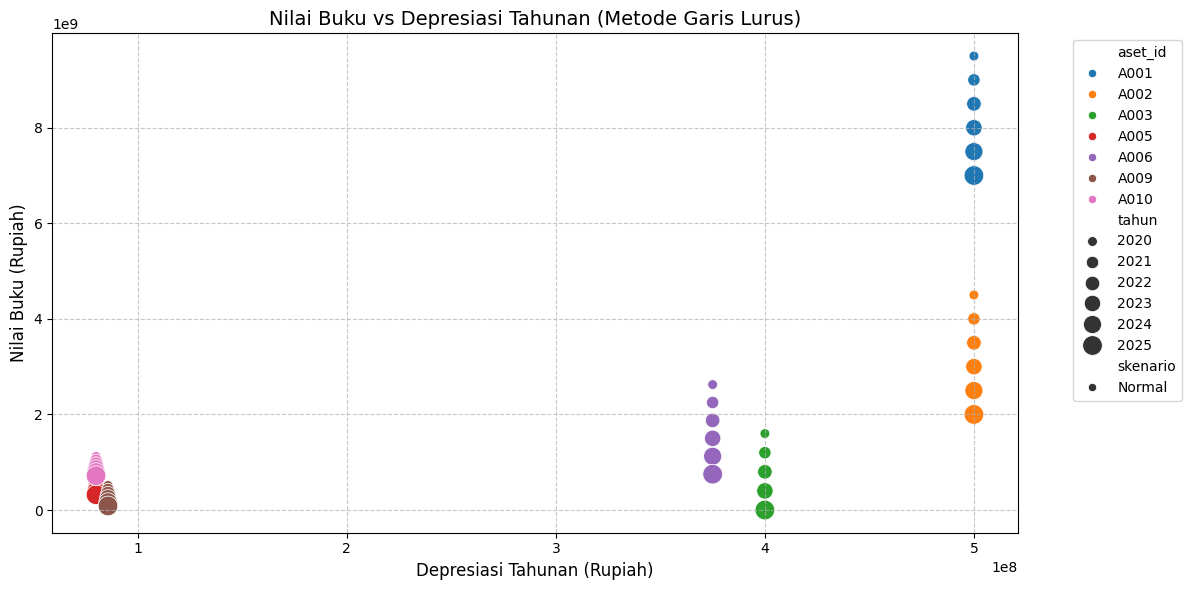

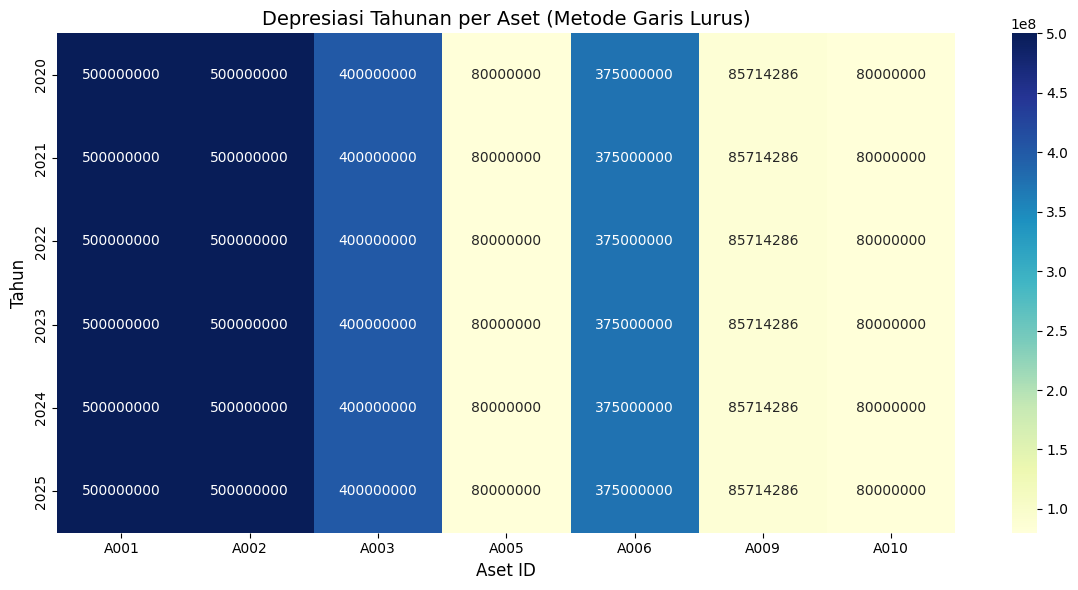

<Figure size 1200x600 with 0 Axes>

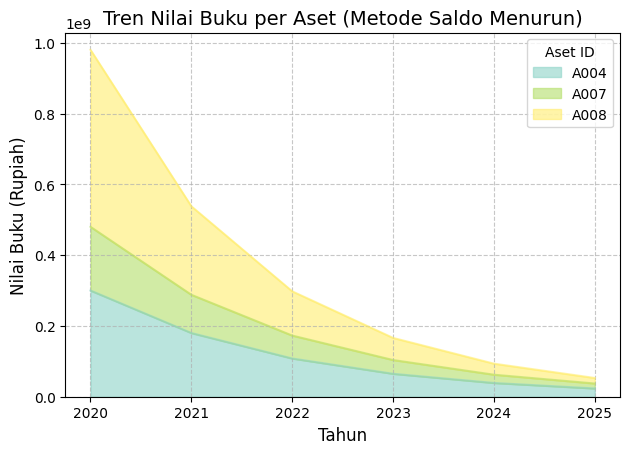

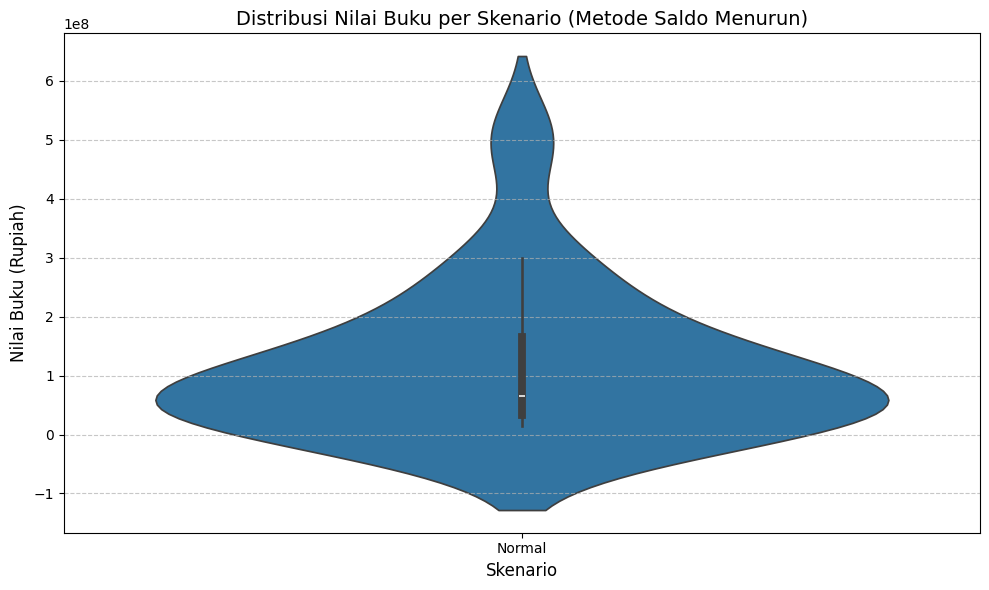

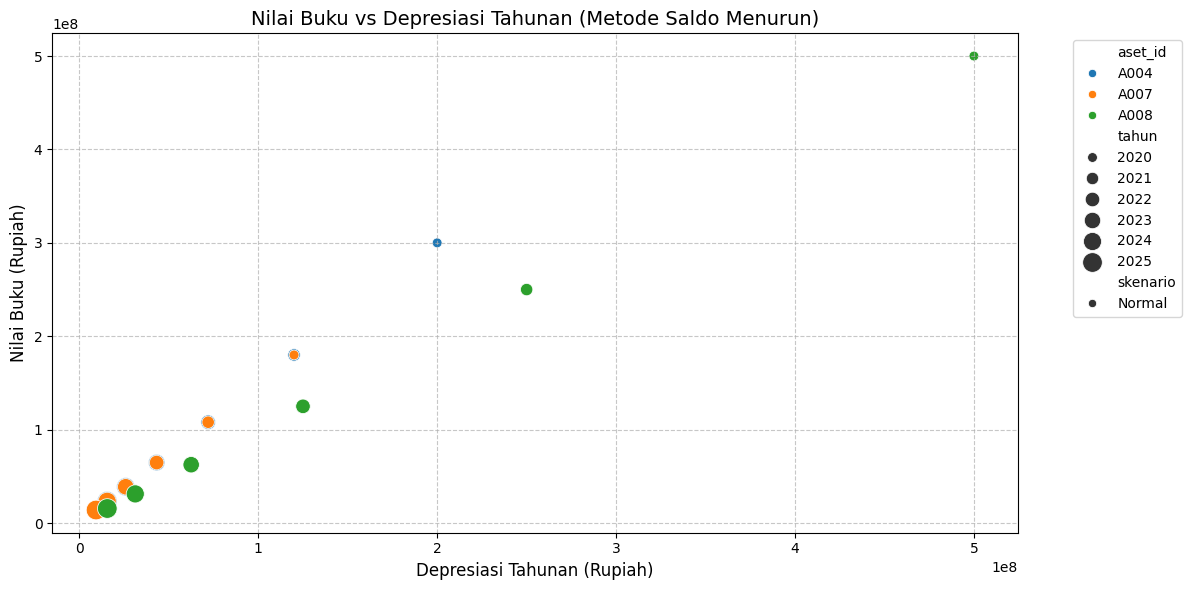

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df, depresiasi_garis_lurus_df, and depresiasi_saldo_menurun_df are available from previous steps

# Visualization 1: Heatmap of Correlation Between Financial Metrics (Tax Holiday Analysis)
plt.figure(figsize=(10, 8))
correlation_matrix = df[['pendapatan', 'beban_operasional', 'penyusutan', 'laba_sebelum_pajak', 'laba_bersih_dengan_tax_holiday']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Heatmap Korelasi Metrik Keuangan', fontsize=14)
plt.tight_layout()
plt.savefig('korelasi_metrik_keuangan_heatmap.png')
plt.show()

# Visualization 2: Area Plot of Tax Savings by Scenario (Tax Holiday Analysis)
plt.figure(figsize=(12, 6))
pivot_df = df.pivot_table(index='tahun', columns='skenario', values='penghematan_pajak', aggfunc='mean')
pivot_df.fillna(0).plot(kind='area', stacked=True, alpha=0.6, cmap='Set2')
plt.title('Penghematan Pajak per Tahun Berdasarkan Skenario', fontsize=14)
plt.xlabel('Tahun', fontsize=12)
plt.ylabel('Penghematan Pajak (Rupiah)', fontsize=12)
plt.legend(title='Skenario')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(sorted(df['tahun'].unique()))
plt.tight_layout()
plt.savefig('penghematan_pajak_area_plot.png')
plt.show()

# Visualization 3: Violin Plot of Net Profit Distribution by Scenario (Tax Holiday Analysis)
plt.figure(figsize=(10, 6))
laba_melted = pd.melt(df, id_vars=['skenario'], value_vars=['laba_bersih_dengan_tax_holiday', 'laba_bersih_tanpa_tax_holiday'],
                      var_name='Kondisi', value_name='Laba Bersih')
laba_melted['Kondisi'] = laba_melted['Kondisi'].replace({
    'laba_bersih_dengan_tax_holiday': 'Dengan Tax Holiday',
    'laba_bersih_tanpa_tax_holiday': 'Tanpa Tax Holiday'
})
sns.violinplot(x='skenario', y='Laba Bersih', hue='Kondisi', data=laba_melted, split=True)
plt.title('Distribusi Laba Bersih per Skenario (Violin Plot)', fontsize=14)
plt.xlabel('Skenario', fontsize=12)
plt.ylabel('Laba Bersih (Rupiah)', fontsize=12)
plt.legend(title='Kondisi')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('distribusi_laba_bersih_violinplot.png')
plt.show()

# Visualization 4: Scatter Plot of Book Value vs. Annual Depreciation (Straight-Line Depreciation)
plt.figure(figsize=(12, 6))
sns.scatterplot(data=depresiasi_garis_lurus_df, x='depresiasi_tahunan', y='nilai_buku', hue='aset_id', style='skenario', size='tahun', sizes=(50, 200))
plt.title('Nilai Buku vs Depresiasi Tahunan (Metode Garis Lurus)', fontsize=14)
plt.xlabel('Depresiasi Tahunan (Rupiah)', fontsize=12)
plt.ylabel('Nilai Buku (Rupiah)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('nilai_buku_vs_depresiasi_garis_lurus_scatter.png')
plt.show()

# Visualization 5: Heatmap of Annual Depreciation by Asset (Straight-Line Depreciation)
plt.figure(figsize=(12, 6))
pivot_df = depresiasi_garis_lurus_df.pivot_table(index='tahun', columns='aset_id', values='depresiasi_tahunan', aggfunc='sum')
sns.heatmap(pivot_df, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Depresiasi Tahunan per Aset (Metode Garis Lurus)', fontsize=14)
plt.xlabel('Aset ID', fontsize=12)
plt.ylabel('Tahun', fontsize=12)
plt.tight_layout()
plt.savefig('depresiasi_tahunan_garis_lurus_heatmap.png')
plt.show()

# Visualization 6: Area Plot of Book Value by Asset (Double Declining Balance)
plt.figure(figsize=(12, 6))
pivot_df = depresiasi_saldo_menurun_df.pivot_table(index='tahun', columns='aset_id', values='nilai_buku', aggfunc='sum')
pivot_df.fillna(0).plot(kind='area', stacked=True, alpha=0.6, cmap='Set3')
plt.title('Tren Nilai Buku per Aset (Metode Saldo Menurun)', fontsize=14)
plt.xlabel('Tahun', fontsize=12)
plt.ylabel('Nilai Buku (Rupiah)', fontsize=12)
plt.legend(title='Aset ID')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(sorted(depresiasi_saldo_menurun_df['tahun'].unique()))
plt.tight_layout()
plt.savefig('tren_nilai_buku_saldo_menurun_area_plot.png')
plt.show()

# Visualization 7: Violin Plot of Book Value Distribution by Scenario (Double Declining Balance)
plt.figure(figsize=(10, 6))
sns.violinplot(x='skenario', y='nilai_buku', data=depresiasi_saldo_menurun_df)
plt.title('Distribusi Nilai Buku per Skenario (Metode Saldo Menurun)', fontsize=14)
plt.xlabel('Skenario', fontsize=12)
plt.ylabel('Nilai Buku (Rupiah)', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('distribusi_nilai_buku_saldo_menurun_violinplot.png')
plt.show()

# Visualization 8: Scatter Plot of Book Value vs. Annual Depreciation (Double Declining Balance)
plt.figure(figsize=(12, 6))
sns.scatterplot(data=depresiasi_saldo_menurun_df, x='depresiasi_tahunan', y='nilai_buku', hue='aset_id', style='skenario', size='tahun', sizes=(50, 200))
plt.title('Nilai Buku vs Depresiasi Tahunan (Metode Saldo Menurun)', fontsize=14)
plt.xlabel('Depresiasi Tahunan (Rupiah)', fontsize=12)
plt.ylabel('Nilai Buku (Rupiah)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('nilai_buku_vs_depresiasi_saldo_menurun_scatter.png')
plt.show()

# Download visualizations
from google.colab import files
files.download('korelasi_metrik_keuangan_heatmap.png')
files.download('penghematan_pajak_area_plot.png')
files.download('distribusi_laba_bersih_violinplot.png')
files.download('nilai_buku_vs_depresiasi_garis_lurus_scatter.png')
files.download('depresiasi_tahunan_garis_lurus_heatmap.png')
files.download('tren_nilai_buku_saldo_menurun_area_plot.png')
files.download('distribusi_nilai_buku_saldo_menurun_violinplot.png')
files.download('nilai_buku_vs_depresiasi_saldo_menurun_scatter.png')